In [220]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from numpy import linalg as LA

In [221]:
img = cv2.imread('./data/dog.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
shape = img.shape
print(shape)

(1197, 1200, 3)


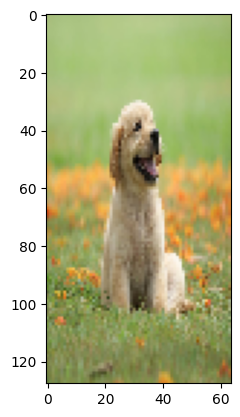

In [222]:
img = cv2.resize(img,(64,128))
plt.imshow(img)
# img to gray
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)    

In [223]:
def global_image_normalization_gamma(img, gamma=2):
    img = img / 255.0
    img = np.power(img, gamma)
    return img

# gray = global_image_normalization_gamma(gray, 2)


### compute gradients

In [224]:
# gray = [[1,2,3,4],[6,7,8,9],[11,12,13,14],[16,17,18,19],[21,22,23,24]]
# gray = np.array(gray)
xkernel = np.array([[-1,0,1]])
ykernel = np.array([[-1],[0],[1]])

dx = cv2.filter2D(gray, cv2.CV_32F, xkernel)
dy = cv2.filter2D(gray, cv2.CV_32F, ykernel)

# print(gray)
print(dx[1] )

gy_check, gx_check = np.gradient(gray) # Note that the result of np.gradient is in the reversed order
print(gx_check[1])
print('diff_gx:', np.linalg.norm(dx - gx_check))
print('diff_gy', np.linalg.norm(dy - gy_check))

[ 0.  1.  2.  2.  1.  2.  0. -1.  0.  0.  1.  1.  1.  1.  1.  1.  2.  3.
  2.  1.  0.  0.  0.  0.  0.  1.  2.  1.  2.  2.  0.  1.  0. -3. -2.  0.
  0.  0.  0. -1. -1.  1.  0. -4. -3. -3. -3.  0. -1. -1. -1. -1. -1. -1.
 -2. -3. -1.  0. -1. -2. -3. -3. -1.  0.]
[ 1.   0.5  1.   1.   0.5  1.   0.  -0.5  0.   0.   0.5  0.5  0.5  0.5
  0.5  0.5  1.   1.5  1.   0.5  0.   0.   0.   0.   0.   0.5  1.   0.5
  1.   1.   0.   0.5  0.  -1.5 -1.   0.   0.   0.   0.  -0.5 -0.5  0.5
  0.  -2.  -1.5 -1.5 -1.5  0.  -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -1.  -1.5
 -0.5  0.  -0.5 -1.  -1.5 -1.5 -0.5  0. ]
diff_gx: 1067.8399926955349
diff_gy 806.767004778951


### compute magnitude and direction of gradients (độ lớn và hướng của gradient)

In [225]:
def magnitude(gx, gy):
    return np.sqrt(gx**2 + gy**2)
    
def direction(gx, gy):
    return np.arctan(np.divide(gy,gx + 1e-5))

d = direction(dx, dy)
d = np.degrees(d) # radian to degree conversion -90 to 90
d = d + 90 # 0 to 180

### compute histogram of gradients 9 bins [0, 20, 40, 60, 80, 100, 120, 140, 160]
- 128x64 -> 8x8 cells -> 9 bins -> 16x8x9


In [226]:
def find_val_his(d, bins):
    k = next((i for i, m in enumerate(bins) if d < m), None)
    if k is None:
        return "Số x nằm ngoài các khoảng."
    else:
        k_truoc = bins[k - 1]
        k_sau = bins[k]
        # Xác định x nằm gần mốc nào hơn
        if abs(d - k_truoc) < abs(d - k_sau):
            return k_truoc, k_sau
        else:
            return k_sau, k_truoc

           
            
def histograms(magnitude,directions,bins, cell_size):
    num_cell_x = magnitude.shape[1]//cell_size
    num_cell_y = magnitude.shape[0]//cell_size
    histogram = np.zeros([num_cell_y,num_cell_x,bins])
    histogram1 = np.zeros([num_cell_y,num_cell_x,bins])
    for i in range(num_cell_y):
        for j in range(num_cell_x):
            dir = directions[i*cell_size:(i+1)*cell_size,j*cell_size:(j+1)*cell_size]
            mag = magnitude[i*cell_size:(i+1)*cell_size,j*cell_size:(j+1)*cell_size]
            hist, _ = np.histogram(dir, bins=bins, range=(0, 180), weights=mag)
            histogram1[i,j,:] = hist
            for k in range(cell_size):
                for l in range(cell_size):
                    dir_cell = dir[k,l]
                    mag_cell = mag[k,l]
                    # a,b = find_val_his(dir_cell,[0,20,40,60,80,100,120,140,160,180])
                    # bin1 = a // 20
                    # bin2 = b // 20
                    # if bin1 !=9:
                    #     histogram[i,j,bin1] += (mag_cell * abs(b - dir_cell) / 20)
                    # if bin2 !=9:
                    #     histogram[i,j,bin2] += (mag_cell * abs(a - dir_cell) / 20)
                    histogram[i,j,int(dir_cell//20)] += mag_cell
    return histogram, histogram1
                    
his,his1 = histograms(magnitude(dx,dy),d,9,8)

### Normalization of HOG blocks
- L2-norm
- L2-Hys (L2-norm followed by clipping and renormalization)
- L1-norm
- L1-sqrt (L1-norm followed by taking the square root)

### Block normalization
- 2x2 blocks
16x8x9 -> 15x7x36 = 3780 features


In [227]:
def normalization_gradients(histogram, cell_size, block_size, eps=1e-5):
    num_cell_x = histogram.shape[1]
    num_cell_y = histogram.shape[0]
    feature_vector = []
    for i in range(num_cell_y-block_size+1):
        for j in range(num_cell_x-block_size+1):
            block = histogram[i:i+block_size,j:j+block_size,:]
            x = block.ravel()
            # x = x / LA.norm(x,2)
            x = x / np.sqrt(np.sum(x**2) + eps**2)
            feature_vector.extend(x)
            
    feature_vector = np.array(feature_vector)
    return feature_vector

print(normalization_gradients(his,8,2))

[0.04742102 0.         0.08508506 ... 0.08858198 0.06432115 0.31969454]


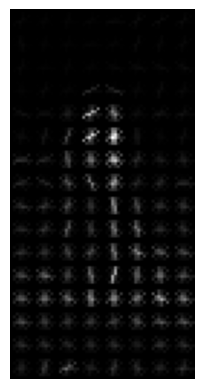

In [228]:
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt


fd, hog_image = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=True)
plt.axis("off")
plt.imshow(hog_image, cmap="gray")
plt.show()

In [229]:
print(fd)

[0.27548216 0.11851144 0.27548216 ... 0.11709378 0.08473509 0.14530461]
